<a href="https://colab.research.google.com/github/vishu17-vains/Deep-learning/blob/main/Rain_prediction_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import numpy as np
import pandas as pd
np.random.seed(0)

LOADING THE DATASET

In [6]:
data = pd.read_csv('weatherAUS.csv')

In [7]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


this dataset contains 10 years of data, weather observation of different locations in australia.
In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           21900 non-null  object 
 1   Location       21900 non-null  object 
 2   MinTemp        21453 non-null  float64
 3   MaxTemp        21573 non-null  float64
 4   Rainfall       21398 non-null  float64
 5   Evaporation    7520 non-null   float64
 6   Sunshine       4876 non-null   float64
 7   WindGustDir    18216 non-null  object 
 8   WindGustSpeed  18218 non-null  float64
 9   WindDir9am     18919 non-null  object 
 10  WindDir3pm     20027 non-null  object 
 11  WindSpeed9am   21189 non-null  float64
 12  WindSpeed3pm   20510 non-null  float64
 13  Humidity9am    21408 non-null  float64
 14  Humidity3pm    20714 non-null  float64
 15  Pressure9am    18310 non-null  float64
 16  Pressure3pm    18314 non-null  float64
 17  Cloud9am       12162 non-null  float64
 18  Cloud3

Points to notice:

There are missing values in the dataset,
Dataset includes numeric and categorical values


DATA VISUALIZATION AND CLEANING


<ipython-input-9-226b9283729a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

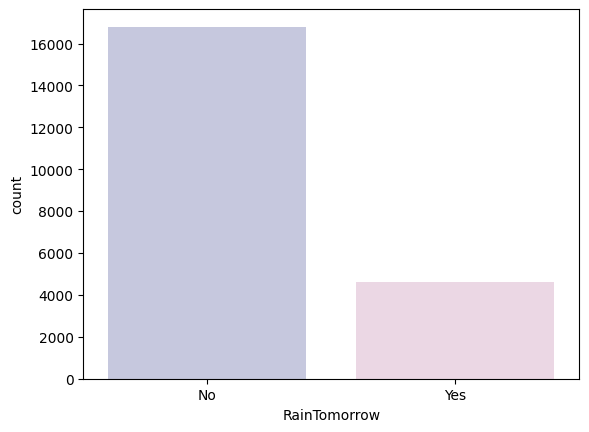

In [9]:
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

<Axes: >

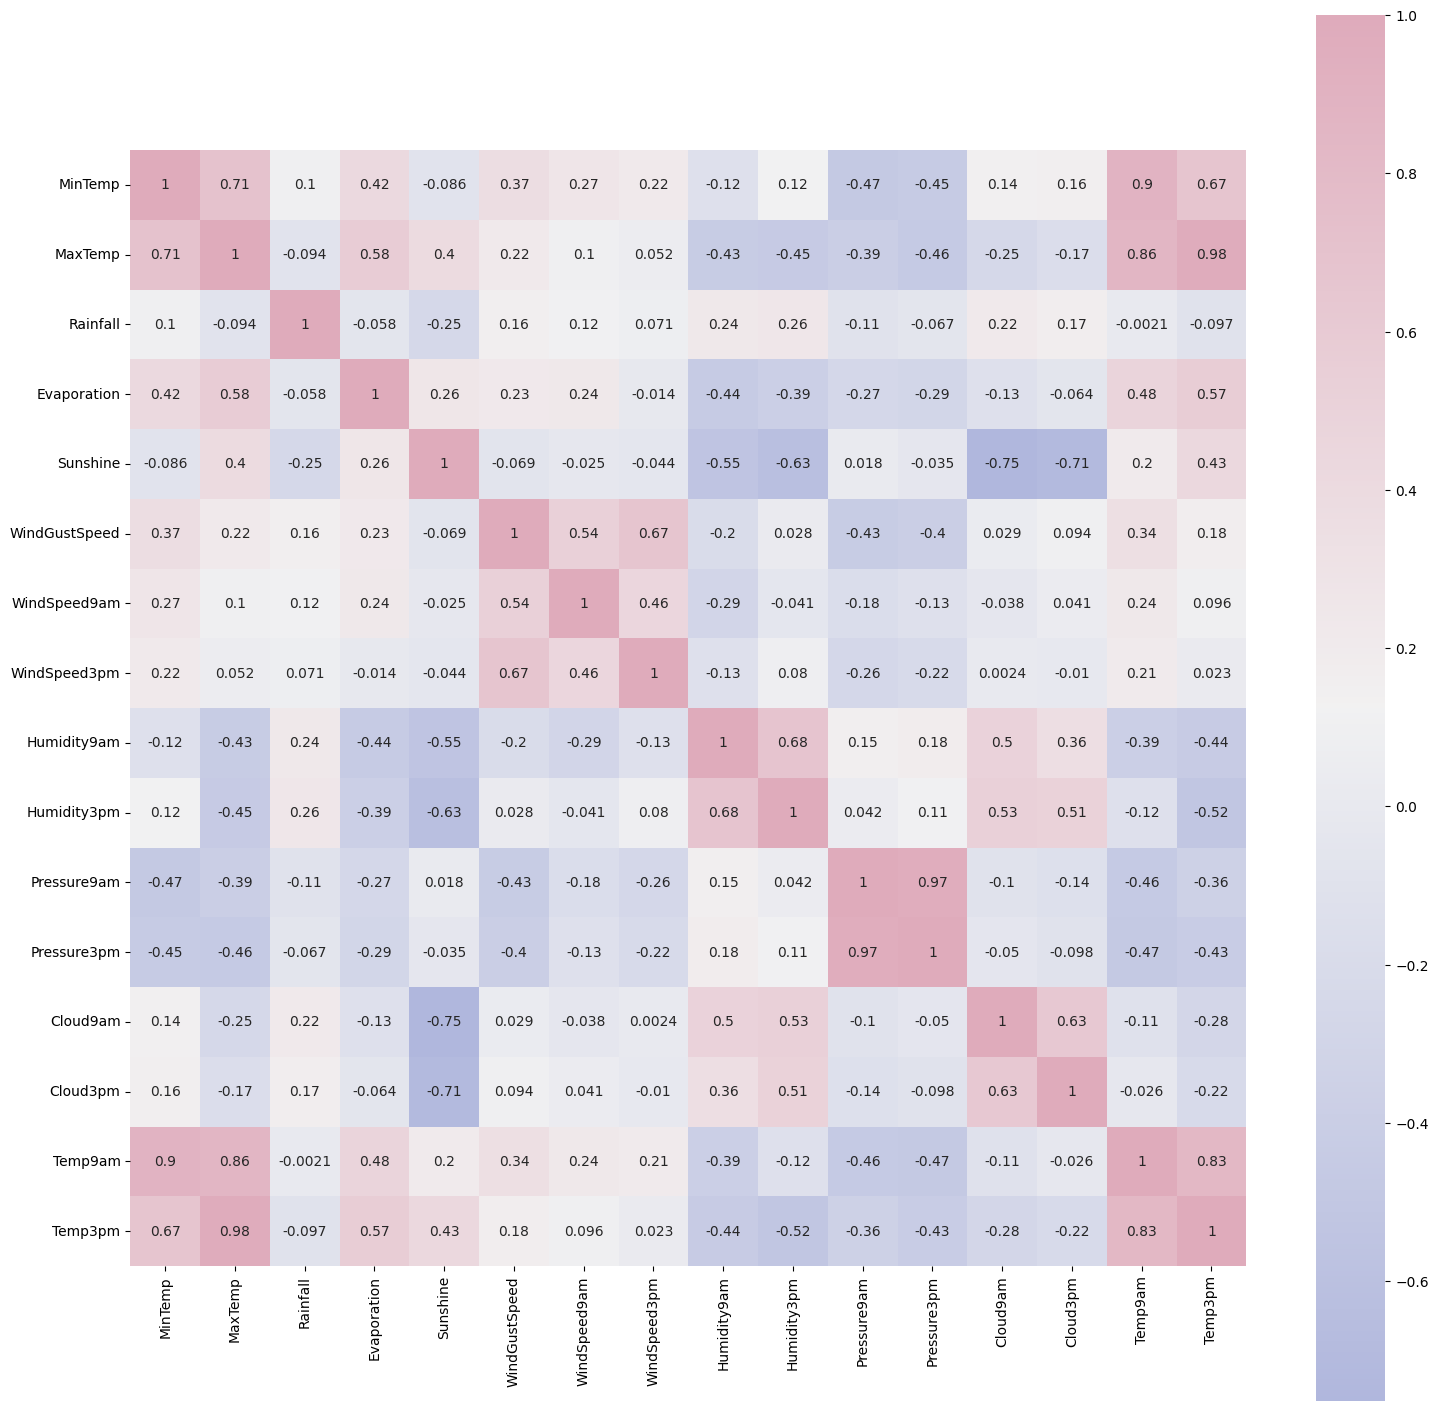

In [13]:
# Correlation amongst numeric attributes
# Convert 'Date' column to datetime objects if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Extract numeric features for correlation analysis
numeric_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
corrmat = numeric_data.corr()

cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)

In [15]:
#Parsing datetime
#exploring the length of date objects
# Convert the 'Date' column back to strings before applying .str.len()
lengths = data["Date"].dt.strftime('%Y-%m-%d').str.len()
lengths.value_counts()

,count
Date,
10,21900


In [16]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

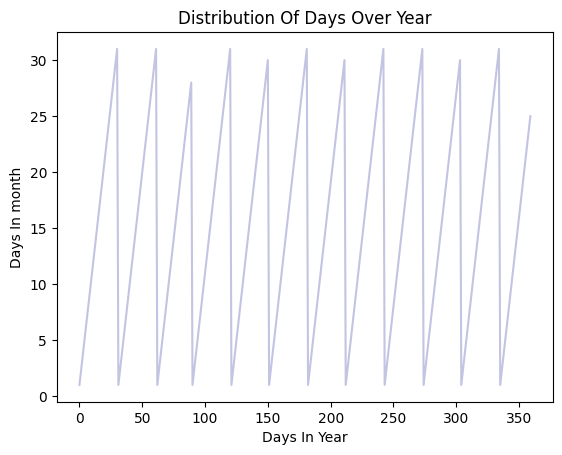

In [17]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

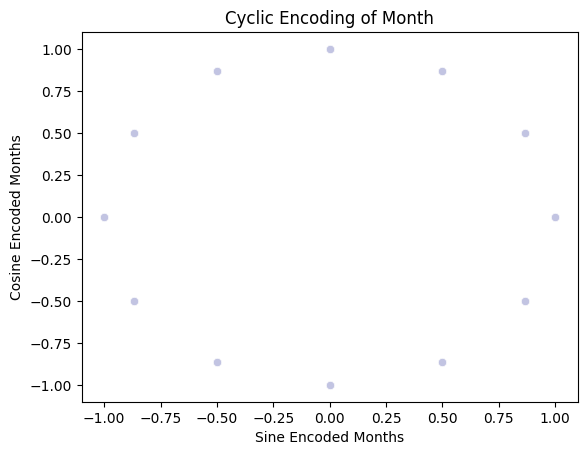

In [18]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

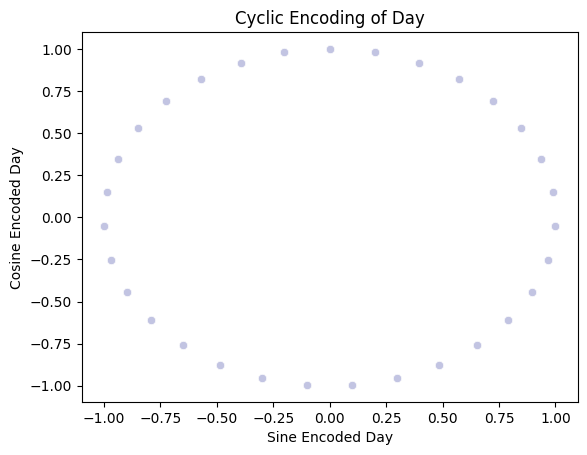

In [19]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Next, I will deal with missing values in categorical and numeric attributes separately

Categorical variables

Filling missing values with mode of the column value

In [20]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [21]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 3684
WindDir9am 2981
WindDir3pm 1873
RainToday 502
RainTomorrow 502


In [22]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

<ipython-input-22-c47c2d6da7f2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


Numerical variables

Filling missing values with median of the column value

In [23]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [24]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 447
MaxTemp 327
Rainfall 502
Evaporation 14380
Sunshine 17024
WindGustSpeed 3682
WindSpeed9am 711
WindSpeed3pm 1390
Humidity9am 492
Humidity3pm 1186
Pressure9am 3590
Pressure3pm 3586
Cloud9am 9738
Cloud3pm 10050
Temp9am 349
Temp3pm 1037
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [25]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           21900 non-null  datetime64[ns]
 1   Location       21900 non-null  object        
 2   MinTemp        21900 non-null  float64       
 3   MaxTemp        21900 non-null  float64       
 4   Rainfall       21900 non-null  float64       
 5   Evaporation    21900 non-null  float64       
 6   Sunshine       21900 non-null  float64       
 7   WindGustDir    21900 non-null  object        
 8   WindGustSpeed  21900 non-null  float64       
 9   WindDir9am     21900 non-null  object        
 10  WindDir3pm     21900 non-null  object        
 11  WindSpeed9am   21900 non-null  float64       
 12  WindSpeed3pm   21900 non-null  float64       
 13  Humidity9am    21900 non-null  float64       
 14  Humidity3pm    21900 non-null  float64       
 15  Pressure9am    2190

<ipython-input-25-4b03adfd6c01>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].median(), inplace=True)


DATA PREPROCESSING


Steps involved in Data Preprocessing:

Label encoding columns with categorical data,
Perform the scaling of the features,
Detecting outliers,
Dropping the outliers based on data analysis.

In [26]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           21900 non-null  datetime64[ns]
 1   Location       21900 non-null  int64         
 2   MinTemp        21900 non-null  float64       
 3   MaxTemp        21900 non-null  float64       
 4   Rainfall       21900 non-null  float64       
 5   Evaporation    21900 non-null  float64       
 6   Sunshine       21900 non-null  float64       
 7   WindGustDir    21900 non-null  int64         
 8   WindGustSpeed  21900 non-null  float64       
 9   WindDir9am     21900 non-null  int64         
 10  WindDir3pm     21900 non-null  int64         
 11  WindSpeed9am   21900 non-null  float64       
 12  WindSpeed3pm   21900 non-null  float64       
 13  Humidity9am    21900 non-null  float64       
 14  Humidity3pm    21900 non-null  float64       
 15  Pressure9am    2190

In [27]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,21900.0,-1.245883e-16,1.000023,-1.494752,-1.018785,-0.066853,0.885080,1.837013
MinTemp,21900.0,-8.305888e-17,1.000023,-2.757029,-0.749182,0.077578,0.803102,2.810949
MaxTemp,21900.0,4.152944e-17,1.000023,-2.776519,-0.752123,-0.082638,0.634668,3.679233
Rainfall,21900.0,1.816913e-17,1.000023,-0.266260,-0.266260,-0.266260,-0.224789,38.198338
Evaporation,21900.0,2.595590e-17,1.000023,-1.671159,-0.146794,-0.146794,-0.146794,25.703898
Sunshine,21900.0,-4.178900e-16,1.000023,-4.906415,0.142756,0.142756,0.142756,2.694488
WindGustDir,21900.0,-4.152944e-17,1.000023,-1.640090,-0.732944,-0.506158,0.854560,1.761705
WindGustSpeed,21900.0,-1.038236e-17,1.000023,-2.515521,-0.599770,-0.183303,0.483045,8.146047
WindDir9am,21900.0,1.038236e-16,1.000023,-1.820062,-0.924517,0.194914,0.866573,1.538231
WindDir3pm,21900.0,1.816913e-17,1.000023,-1.786090,-0.849806,0.320549,0.788691,1.724975


<ipython-input-28-6d42aad80754>:5: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


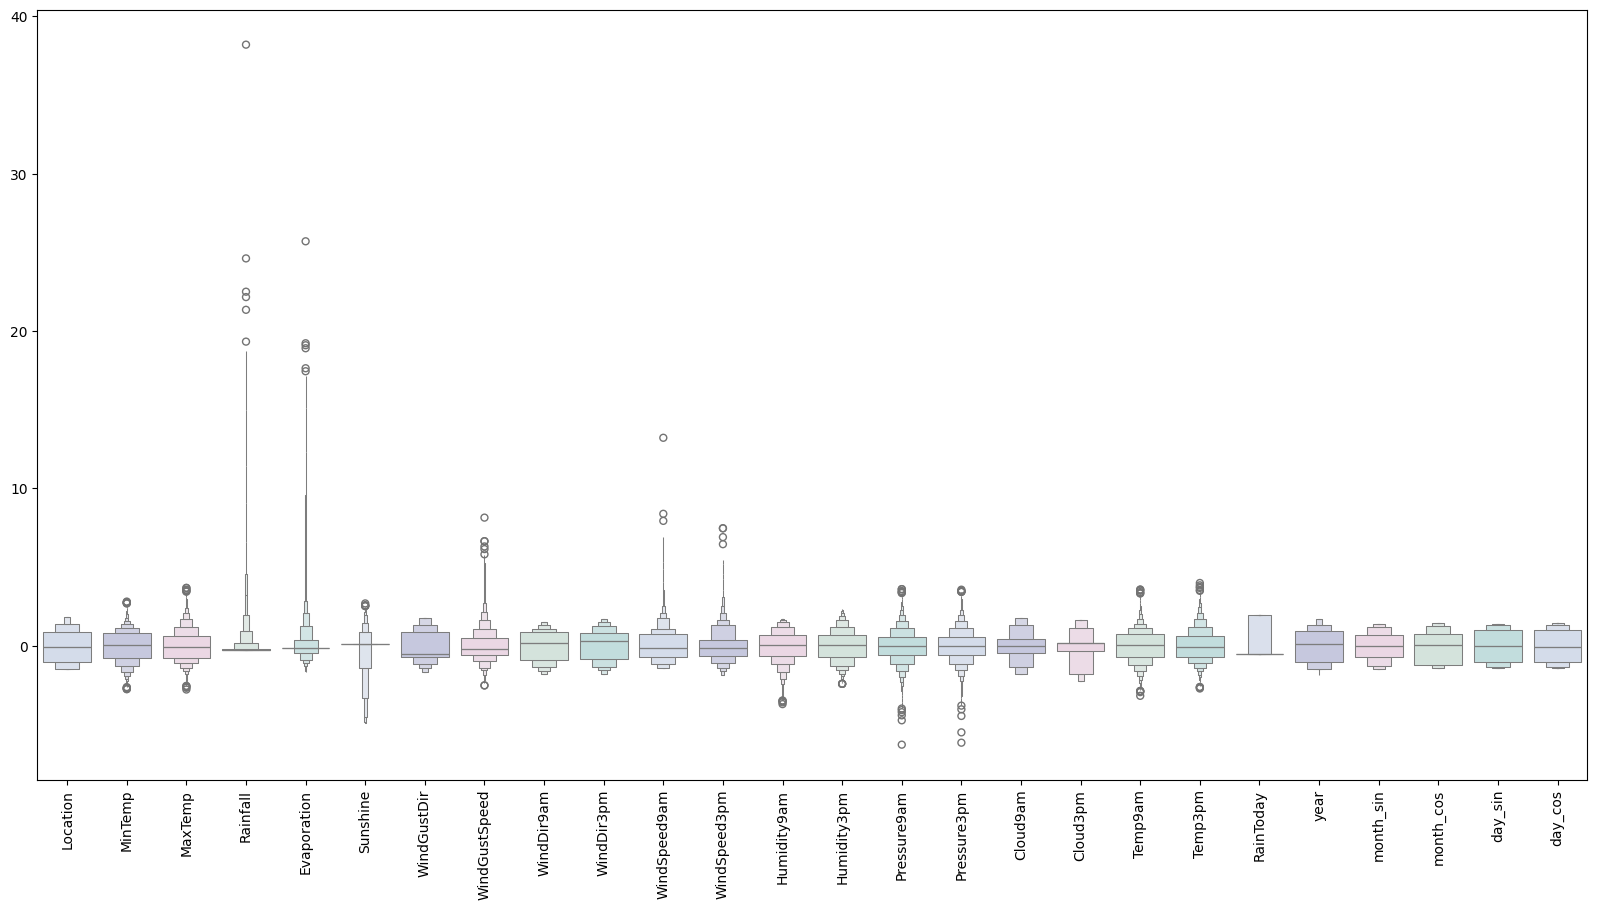

In [28]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [29]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(18794, 27)

<ipython-input-30-0b9d7aa52ee8>:4: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


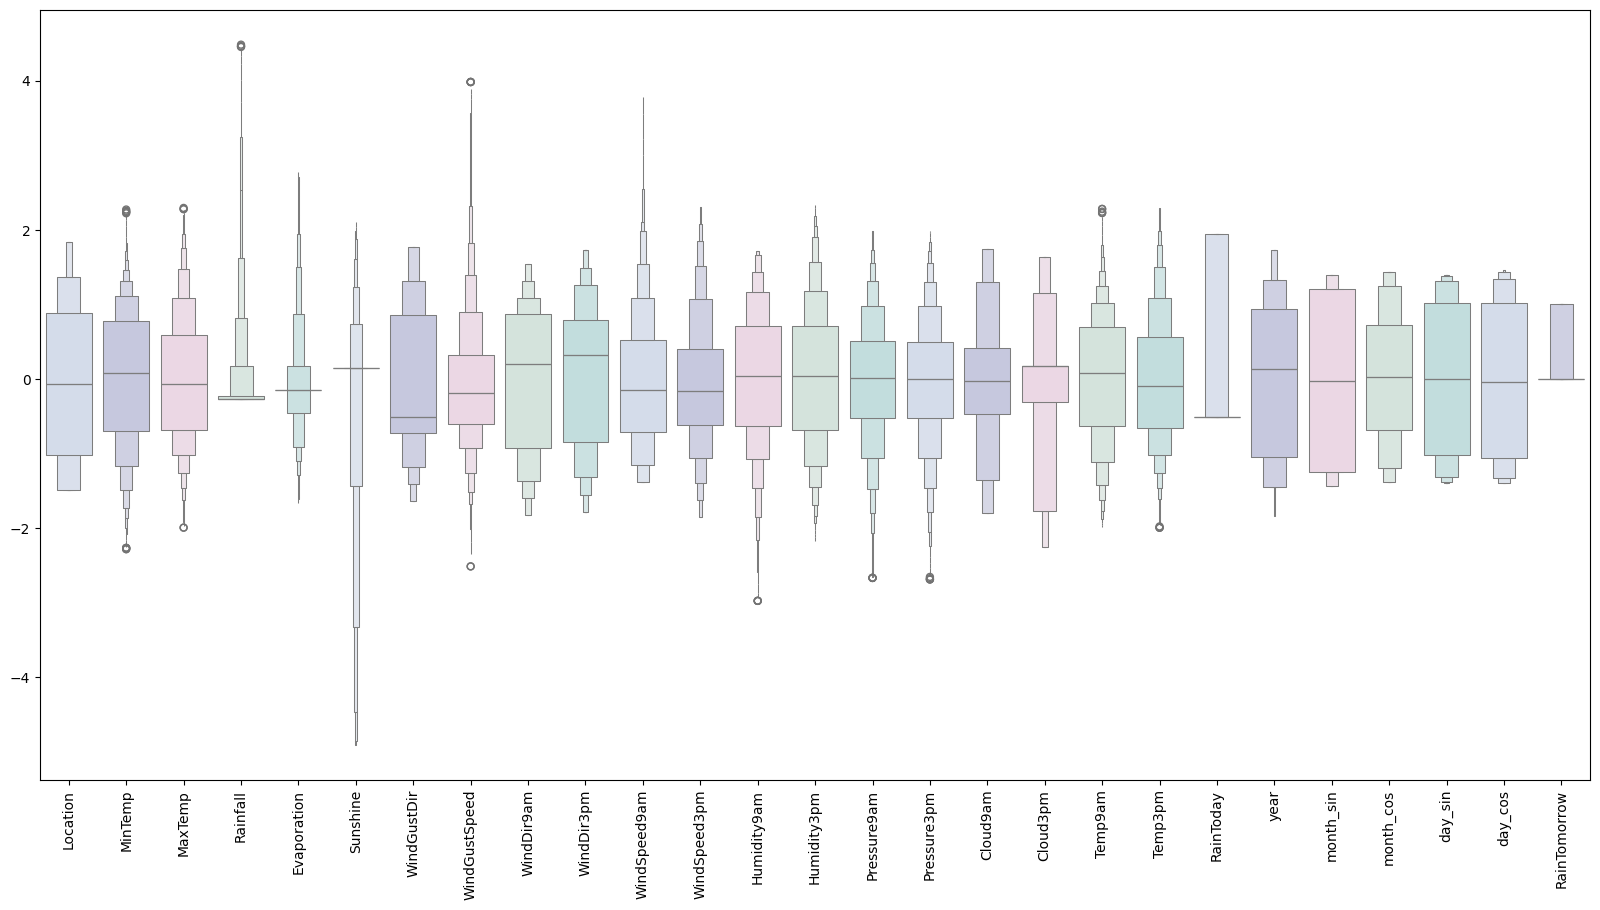

In [30]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

FROM HERE IVE TO CREATE ARTIFICIAL NEURAL NETWORK

Following are steps involved in building an Artificial neural network

Assining X and y the status of attributes and tags

Splitting test and training sets

Initialising the neural network

Defining by adding layers

Compiling the neural network

Train the neural network

In [31]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(18794, 26)

In [32]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
#Early Stopping is a regularization technique used in deep learning to prevent overfitting and improve the generalization of a model.
#It works by monitoring the model's performance on a validation set during training and stopping the training process when the performance stops improving.

In [33]:
# Initialising the NN
model = Sequential()

In [35]:
# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))

model.add(Dropout(0.25))
#Dropout: Regularization technique to prevent overfitting.
#rate=0.25: Randomly sets 25% of the neurons in the previous layer to 0 during training.
#This forces the model to not rely on specific neurons and learn a more generalized representation of the data.

model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [36]:
# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [37]:
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7953 - loss: 0.6895 - val_accuracy: 0.7908 - val_loss: 0.6677
Epoch 2/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7916 - loss: 0.6405 - val_accuracy: 0.7908 - val_loss: 0.5320
Epoch 3/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7918 - loss: 0.5374 - val_accuracy: 0.7908 - val_loss: 0.4963
Epoch 4/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7930 - loss: 0.5162 - val_accuracy: 0.7908 - val_loss: 0.4914
Epoch 5/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7974 - loss: 0.5107 - val_accuracy: 0.7908 - val_loss: 0.4879
Epoch 6/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7986 - loss: 0.5051 - val_accuracy: 0.7908 - val_loss: 0.4844
Epoch 7/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7926 - loss: 0.5126 - val_accuracy: 0.7908 - val_loss: 0.4807
Epoch 8/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7954 - loss: 0.5003 - val_ac

Setting epochs=150 means the model will iterate over the entire dataset 150 times unless stopped earlier by a callback (e.g., early stopping).

Plotting training and validation loss over epochs

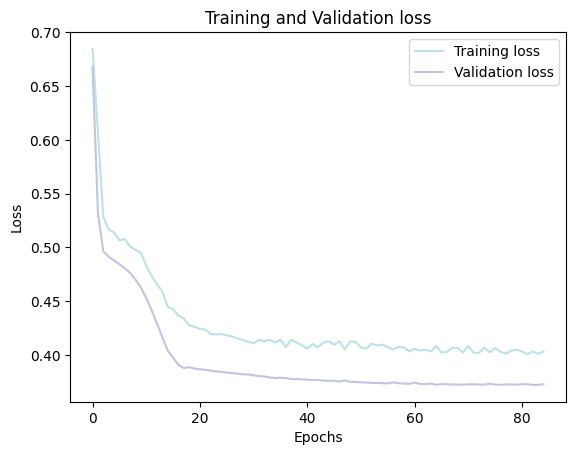

In [38]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs


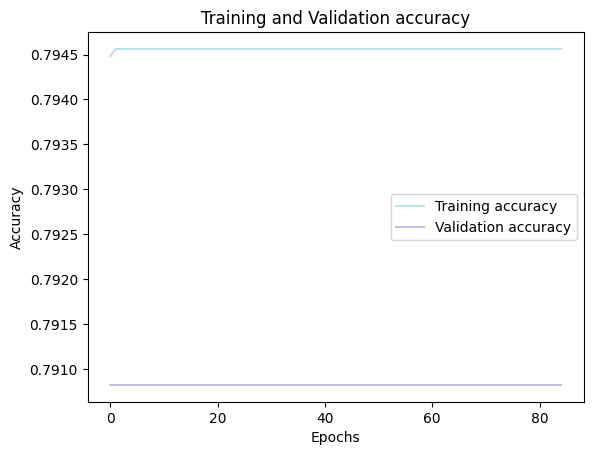

In [40]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CONCLUSION

Testing on the test set

Evaluating the confusion matrix

Evaluating the classification report

In [41]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Axes: >

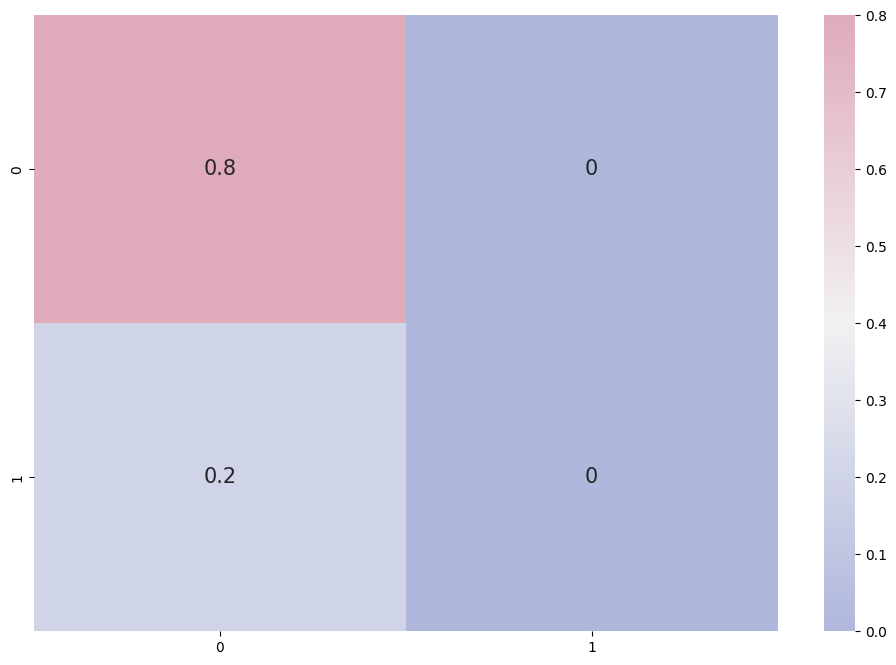

In [43]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3008
           1       0.00      0.00      0.00       751

    accuracy                           0.80      3759
   macro avg       0.40      0.50      0.44      3759
weighted avg       0.64      0.80      0.71      3759



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
